<a href="https://colab.research.google.com/github/butter-my-toast/TrafficCollisionML/blob/main/traffic_collision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
import os
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from google.colab.data_table import DataTable
DataTable.max_columns = 75

First, let's download the Kaggle dataset.

In [2]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d alexgude/california-traffic-collision-data-from-switrs
! unzip -q california-traffic-collision-data-from-switrs.zip

Saving kaggle.json to kaggle.json
100% 1.50G/1.50G [01:12<00:00, 23.0MB/s]
100% 1.50G/1.50G [01:12<00:00, 22.3MB/s]


In [3]:
cnx = sqlite3.connect('/content/switrs.sqlite')
cursor = cnx.cursor()

In [4]:
FINAL_QUERY = """
SELECT longitude, latitude, intersection, road_surface, lighting, state_highway_indicator, weather_1, weather_2, collision_time, collision_severity, collision_date FROM collisions
"""

df = pd.read_sql(FINAL_QUERY, cnx)
df

,longitude,latitude,intersection,road_surface,lighting,state_highway_indicator,weather_1,weather_2,collision_time,collision_severity,collision_date
0,NaN,NaN,1.0,dry,daylight,0.0,cloudy,None,07:45:00,property damage only,2020-03-14
1,NaN,NaN,NaN,dry,dark with street lights,0.0,clear,None,02:50:00,property damage only,2020-07-26
2,NaN,NaN,1.0,dry,daylight,0.0,clear,None,17:11:00,property damage only,2009-02-03
3,NaN,NaN,0.0,dry,dark with no street lights,1.0,clear,None,01:45:00,property damage only,2009-02-28
4,-118.28533,33.86465,0.0,wet,daylight,1.0,raining,None,10:20:00,property damage only,2009-02-09
...,...,...,...,...,...,...,...,...,...,...,...
9424329,-117.47220,33.43440,NaN,dry,daylight,0.0,clear,None,18:04:00,property damage only,2016-06-12
9424330,-122.18463,37.44952,1.0,dry,daylight,0.0,clear,None,10:00:00,property damage only,2016-05-11
9424331,NaN,NaN,0.0,dry,daylight,1.0,clear,None,15:31:00,pain,2016-08-15
9424332,NaN,NaN,0.0,dry,daylight,0.0,clear,None,07:53:00,pain,2016-08-18


In [5]:
df.isnull().sum()

longitude                  6730338
latitude                   6730338
intersection                 94500
road_surface                 81164
lighting                     53308
state_highway_indicator       3324
weather_1                    45221
weather_2                  9161454
collision_time               82415
collision_severity               0
collision_date                   0
dtype: int64

In [6]:
drop_df = df.dropna(subset=['lighting', 'intersection', 'longitude', 'latitude', 'road_surface', 'state_highway_indicator', 'collision_severity', 'weather_1', 'collision_time'])
drop_df = drop_df.drop(drop_df[drop_df['lighting'] == 'G'].index)
drop_df = drop_df.drop(drop_df[drop_df['road_surface'] == 'H'].index)
drop_df = drop_df.drop(drop_df[drop_df['road_surface'] == 'I'].index)
drop_df = drop_df.drop(drop_df[drop_df['road_surface'] == 'J'].index)
drop_df

,longitude,latitude,intersection,road_surface,lighting,state_highway_indicator,weather_1,weather_2,collision_time,collision_severity,collision_date
4,-118.28533,33.86465,0.0,wet,daylight,1.0,raining,None,10:20:00,property damage only,2009-02-09
5,-118.28230,33.79120,0.0,dry,daylight,1.0,clear,None,15:50:00,property damage only,2009-02-18
6,-118.35260,33.88450,0.0,dry,dusk or dawn,1.0,cloudy,None,17:35:00,property damage only,2009-02-11
7,-118.20906,33.83197,0.0,dry,dark with no street lights,1.0,clear,None,21:20:00,property damage only,2009-02-13
8,-118.20770,33.82693,0.0,dry,dark with no street lights,1.0,clear,None,20:40:00,pain,2009-02-13
...,...,...,...,...,...,...,...,...,...,...,...
9424325,-117.79989,34.02730,0.0,dry,daylight,1.0,clear,None,20:50:00,property damage only,2015-11-30
9424326,-117.39960,34.44470,0.0,dry,daylight,1.0,clear,None,14:25:00,pain,2016-03-23
9424328,-120.41725,34.95313,0.0,dry,dusk or dawn,1.0,clear,None,00:45:00,property damage only,2016-05-28
9424330,-122.18463,37.44952,1.0,dry,daylight,0.0,clear,None,10:00:00,property damage only,2016-05-11


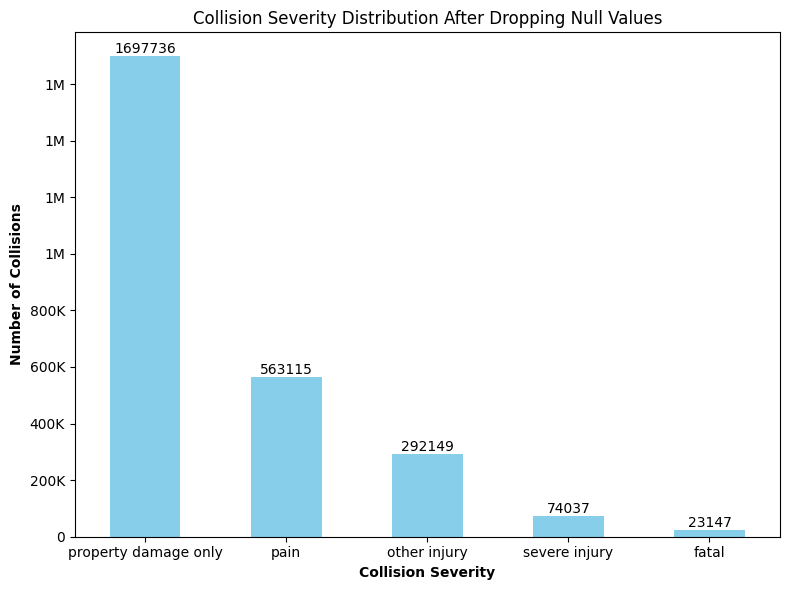

In [7]:
from matplotlib.ticker import FuncFormatter

severity_group_counts = drop_df['collision_severity'].value_counts()

plt.figure(figsize=(8, 6))
ax = severity_group_counts.plot(kind='bar', color='skyblue')
plt.title('Collision Severity Distribution After Dropping Null Values')
plt.xlabel('Collision Severity', fontweight='bold')
plt.ylabel('Number of Collisions', fontweight='bold')
plt.xticks(rotation=0)
def format_large_tick_values(tick_val, tick_pos):
    if tick_val >= 1e6:
        val = int(tick_val / 1e6)
        return f'{val}M'
    elif tick_val >= 1e3:
        val = int(tick_val / 1e3)
        return f'{val}K'
    else:
        return int(tick_val)

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_large_tick_values))

for i, v in enumerate(severity_group_counts):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()

In [8]:
cut_df = pd.DataFrame()
sample_sizes = [90000, 20000, 72000, 10000, 22000] # property, pain, severe, other, fatal
test_df = drop_df.sample(int(0.1*sum(sample_sizes)), random_state = 21)
df_test_removed = drop_df.drop(test_df.index)

for i, severity in enumerate(drop_df['collision_severity'].unique()):
    subset = df_test_removed[df_test_removed['collision_severity'] == severity].sample(sample_sizes[i])
    cut_df = pd.concat([cut_df, subset], ignore_index=True)

cut_df

,longitude,latitude,intersection,road_surface,lighting,state_highway_indicator,weather_1,weather_2,collision_time,collision_severity,collision_date
0,-118.48855,34.31389,0.0,dry,daylight,1.0,clear,None,13:30:00,property damage only,2009-01-08
1,-117.63911,33.45003,0.0,dry,daylight,1.0,clear,None,10:45:00,property damage only,2016-08-02
2,-116.90648,32.79108,0.0,dry,dark with no street lights,0.0,clear,None,21:38:00,property damage only,2018-10-14
3,-118.20190,33.92157,0.0,dry,daylight,1.0,clear,None,08:45:00,property damage only,2012-01-16
4,-118.15616,34.03121,0.0,dry,dark with street lights,0.0,clear,None,19:25:00,property damage only,2009-09-17
...,...,...,...,...,...,...,...,...,...,...,...
213995,-118.18115,33.90846,0.0,dry,dark with street lights,1.0,clear,None,01:20:00,fatal,2019-01-27
213996,-121.02984,37.05679,0.0,dry,daylight,1.0,clear,None,16:05:00,fatal,2020-01-14
213997,-121.99115,38.34852,0.0,wet,dark with no street lights,1.0,raining,None,06:50:00,fatal,2019-02-13
213998,-118.12253,33.49237,0.0,dry,dark with street lights,1.0,clear,None,00:29:00,fatal,2016-08-24


In [9]:
cut_df['collision_severity'].value_counts()

property damage only    90000
severe injury           72000
fatal                   22000
pain                    20000
other injury            10000
Name: collision_severity, dtype: int64

In [10]:
import math

label_mapping = {
    'property damage only': 0,
    'pain': 0,
    'other injury': 0,
    'severe injury': 1,
    'fatal': 1,
    None: None
}

cut_df = pd.get_dummies(cut_df, columns=['weather_1'], prefix='weather_1') # one-hot
cut_df = pd.get_dummies(cut_df, columns=['weather_2'], prefix='weather_2') # one-hot

cut_df = pd.get_dummies(cut_df, columns=['lighting'], prefix='lighting') # one-hot

cut_df['collision_severity'] = cut_df['collision_severity'].map(label_mapping)

cut_df['collision_time'] = pd.to_datetime(cut_df['collision_time'])
cut_df['collision_time'] = cut_df['collision_time'].dt.hour

cut_df = pd.get_dummies(cut_df, columns=['road_surface'], prefix='road_surface') # one-hot

cut_df['collision_date'] = pd.to_datetime(cut_df['collision_date'])
cut_df['weekend'] = cut_df['collision_date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

cut_df['collision_date'] = cut_df['collision_date'].dt.dayofyear

# cyclically-encoding the time
def transformation(column):
  max_value = column.max()
  sin_values = [math.sin((2*math.pi*x)/max_value) for x in list(column)]
  cos_values = [math.cos((2*math.pi*x)/max_value) for x in list(column)]
  return sin_values, cos_values

time_sin_values, time_cos_values = transformation(cut_df['collision_time'])
cut_df['collision_time_sin'] = time_sin_values
cut_df['collision_time_cos'] = time_cos_values

day_sin_values, day_cos_values = transformation(cut_df['collision_date'])
cut_df['collision_date_sin'] = day_sin_values
cut_df['collision_date_cos'] = day_cos_values

cut_df = cut_df.drop(['collision_time', 'collision_date'], axis=1)

test_df = pd.get_dummies(test_df, columns=['weather_1'], prefix='weather_1') # one-hot
test_df = pd.get_dummies(test_df, columns=['weather_2'], prefix='weather_2') # one-hot

test_df = pd.get_dummies(test_df, columns=['lighting'], prefix='lighting') # one-hot

test_df['collision_severity'] = test_df['collision_severity'].map(label_mapping)
test_df['collision_time'] = pd.to_datetime(test_df['collision_time'])
test_df['collision_time'] = test_df['collision_time'].dt.hour

test_df = pd.get_dummies(test_df, columns=['road_surface'], prefix='road_surface') # one-hot

test_df['collision_date'] = pd.to_datetime(test_df['collision_date'])
test_df['weekend'] = test_df['collision_date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

test_df['collision_date'] = test_df['collision_date'].dt.dayofyear

time_sin_values, time_cos_values = transformation(test_df['collision_time'])
test_df['collision_time_sin'] = time_sin_values
test_df['collision_time_cos'] = time_cos_values

day_sin_values, day_cos_values = transformation(test_df['collision_date'])
test_df['collision_date_sin'] = day_sin_values
test_df['collision_date_cos'] = day_cos_values

test_df = test_df.drop(['collision_time', 'collision_date'], axis=1)

cut_df.head()

,longitude,latitude,intersection,state_highway_indicator,collision_severity,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,...,lighting_dusk or dawn,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,weekend,collision_time_sin,collision_time_cos,collision_date_sin,collision_date_cos
0,-118.48855,34.31389,0.0,1.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,-0.398401,-0.917211,0.136906,0.990584
1,-117.63911,33.45003,0.0,1.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,0.398401,-0.917211,-0.522133,-0.852864
2,-116.90648,32.79108,0.0,0.0,0.0,1,0,0,0,0,...,0,1,0,0,0,1,-0.519584,0.854419,-0.977064,0.212947
3,-118.20190,33.92157,0.0,1.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,0.816970,-0.576680,0.271234,0.962513
4,-118.15616,34.03121,0.0,0.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,-0.887885,0.460065,-0.969178,-0.246361


In [11]:
cut_labels = pd.DataFrame(cut_df['collision_severity'])
cut_df = cut_df.drop(['collision_severity'], axis=1)

cut_labels_test = pd.DataFrame(test_df['collision_severity'])
cut_df_test = test_df.drop(['collision_severity'], axis=1)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
X_train, X_test, y_train, y_test = cut_df, cut_df_test, cut_labels, cut_labels_test
y_train, y_test = y_train['collision_severity'].ravel(), y_test['collision_severity'].ravel()

In [13]:
import sklearn.tree as tree
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
tree_preds = tree_clf.predict(X_test)
print('Decision tree acc:', (accuracy_score(y_test, tree_preds)))

Decision tree acc: 0.6213551401869158


In [14]:
from sklearn.ensemble import RandomForestClassifier
forest100_clf = RandomForestClassifier(n_estimators=100)
forest100_clf.fit(X_train, y_train)
forest100_preds = forest100_clf.predict(X_test)
print('Random forest (100) acc:', (accuracy_score(y_test, forest100_preds)))

Random forest (100) acc: 0.6973831775700935


In [15]:
forest500_clf = RandomForestClassifier(n_estimators=500)
forest500_clf.fit(X_train, y_train)
forest500_preds = forest500_clf.predict(X_test)
print('Random forest (500) acc:', (accuracy_score(y_test, forest500_preds)))

Random forest (500) acc: 0.6944859813084112


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
gnb_preds = gnb_clf.predict(X_test)
print('Naive bayes acc:', (accuracy_score(y_test, gnb_preds)))

Naive bayes acc: 0.8456542056074766


In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
knn_preds = knn_clf.predict(X_test)
print('KNN acc:', (accuracy_score(y_test, knn_preds)))

KNN acc: 0.6844859813084112


In [18]:
from sklearn.ensemble import GradientBoostingClassifier
gradboost_clf1 = GradientBoostingClassifier(learning_rate = 0.1)
gradboost_clf1.fit(X_train, y_train)
gradboost_preds1 = gradboost_clf1.predict(X_test)
print('Grad boost (lr=0.1) acc:', (accuracy_score(y_test, gradboost_preds1)))

Grad boost (lr=0.1) acc: 0.736588785046729


In [19]:
gradboost_clf2 = GradientBoostingClassifier(learning_rate = 0.2)
gradboost_clf2.fit(X_train, y_train)
gradboost_preds2 = gradboost_clf2.predict(X_test)
print('Grad boost (lr=0.2) acc:', (accuracy_score(y_test, gradboost_preds2)))

Grad boost (lr=0.2) acc: 0.7275233644859813


In [20]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train, label=y_train)

dtest = xgb.DMatrix(data=X_test, label=y_test)
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',

}
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)
xgb_preds = xgb_model.predict(dtest)
print('xgboost (default hyperparams) acc:', (accuracy_score(y_test, xgb_preds)))

xgboost (default hyperparams) acc: 0.718411214953271


In [21]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': -1,
    'is_unbalance': True,
    'learning_rate': 0.015,
    'num_leaves': 31,
    'max_depth': 5,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8

}
num_round = 1000
lgb_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])
lgb_preds_x = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
lgb_preds = (lgb_preds_x > 0.5).astype(int)
print('lightgbm (default hyperparams) acc:', (accuracy_score(y_test, lgb_preds)))

lightgbm (default hyperparams) acc: 0.6155607476635514


In [31]:
print("Decision tree recall: " + str(recall_score(y_test, tree_preds)))
print("Random forest (n=100) recall: " + str(recall_score(y_test, forest100_preds)))
print("Random forest (n=500) recall: " + str(recall_score(y_test, forest500_preds)))
print("Naive bayes recall: " + str(recall_score(y_test, gnb_preds)))
print("KNN recall: " + str(recall_score(y_test, knn_preds)))
print("Gradient boosting (lr=0.1) recall:" + str(recall_score(y_test, gradboost_preds1)))
print("XGBoost recall: " + str(recall_score(y_test, xgb_preds)))
print("LightGBM recall: " + str(recall_score(y_test, lgb_preds)))

Decision tree recall: 0.5219123505976095
Random forest (n=100) recall: 0.5590969455511288
Random forest (n=500) recall: 0.547144754316069
Naive bayes recall: 0.23904382470119523
KNN recall: 0.50199203187251
Gradient boosting (lr=0.1) recall:0.49800796812749004
XGBoost recall: 0.5564409030544488
LightGBM recall: 0.6826029216467463


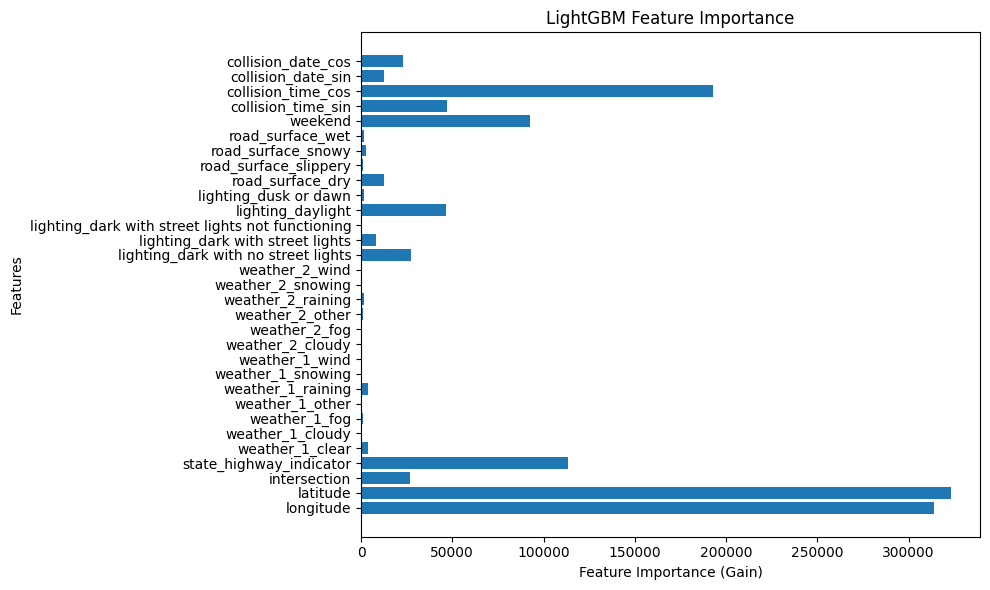

In [32]:
feature_importance = lgb_model.feature_importance(importance_type='gain')
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), feature_importance, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Features')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

In [33]:
import sklearn.metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

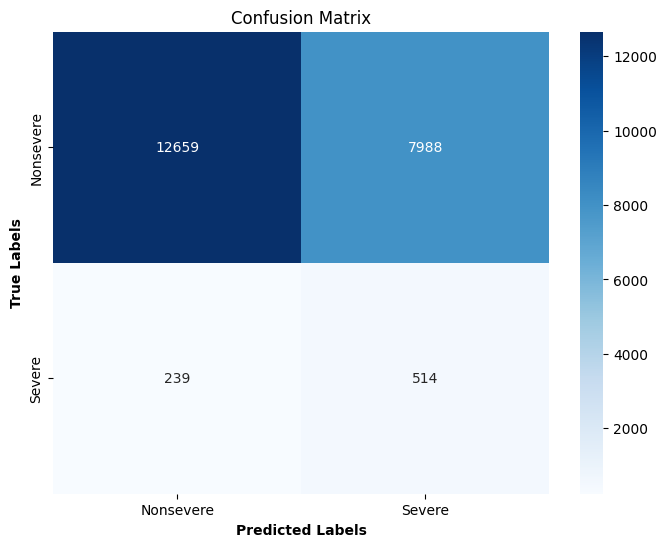

In [36]:
conf_matrix = confusion_matrix(y_test, lgb_preds)
plt.figure(figsize=(8, 6))
labels = ['Nonsevere', 'Severe']
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels", fontweight='bold')
plt.ylabel("True Labels", fontweight='bold')
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

  Non-Severe       0.98      0.61      0.75     20647
      Severe       0.06      0.68      0.11       753

    accuracy                           0.62     21400
   macro avg       0.52      0.65      0.43     21400
weighted avg       0.95      0.62      0.73     21400



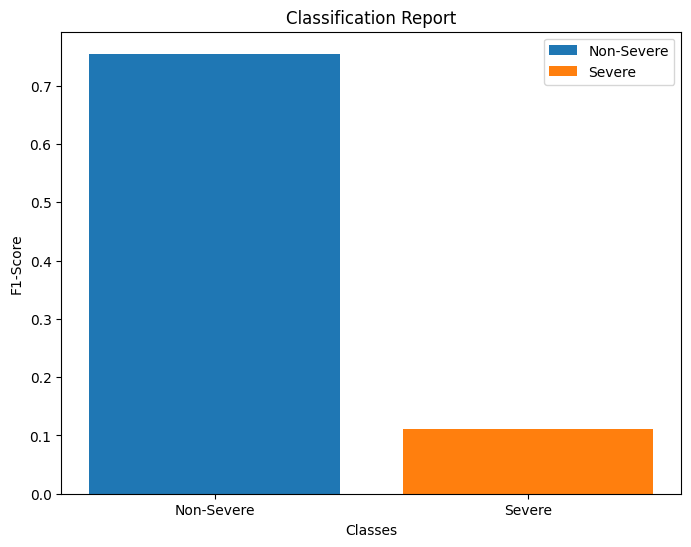

In [38]:
lgb_preds_class = np.round(lgb_preds)

class_names = ['Non-Severe', 'Severe']
report = classification_report(y_test, lgb_preds_class, target_names=class_names, output_dict=True)

print(classification_report(y_test, lgb_preds_class, target_names=class_names))

fig, ax = plt.subplots(figsize=(8, 6))
for key in report.keys():
    row = report[key]
    if key in class_names:
        ax.bar(class_names.index(key), row['f1-score'], label=key)

ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_xlabel('Classes')
ax.set_ylabel('F1-Score')
ax.set_title('Classification Report')
ax.legend()
plt.show()